# Position Reconstruction for XeBRA - Neural Networks

**Status:** July 2019

Position reconstruction for XeBRA using a feedforward neural network with Keras.

## Setup

In [1]:
## Imports:

!python -V

import os
import sys
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec            # to arrange the plots nicely
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

import pandas as pd
print('pandas version = '+str(pd.__version__))
import numpy as np
import math
import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import ast

import keras
print('keras version = '+str(keras.__version__))
from keras.models import Sequential,Model,load_model
from keras.layers import Input,Dense,Dropout,Activation
from keras.optimizers import SGD,Adam
from keras.utils import to_categorical, plot_model

from ann_visualizer.visualize import ann_viz

Python 3.7.3
pandas version = 0.24.2


Using TensorFlow backend.


keras version = 2.2.4


In [2]:
'''
## Fix random seed 

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
''';

In [3]:
## Function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [4]:
## PMT properties

R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.

PMT_ID = np.array([1,2,3,4,5,6,7])

PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates

PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})
PMT_positions

PMT_ID  PMT_position_x  PMT_position_y  PMT_position_R  PMT_position_Phi
1       1           -14.0           -28.0       31.304952         -2.034444
2       2           -28.0             0.0       28.000000          3.141593
3       3           -14.0            28.0       31.304952          2.034444
4       4            14.0            28.0       31.304952          1.107149
5       5            28.0             0.0       28.000000          0.000000
6       6            14.0           -28.0       31.304952         -1.107149
7       7             0.0             0.0        0.000000          0.000000

## Preparing the Data

In [5]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Simulation_Data/LCE/*.root
#! ls ../../Simulation_Data/Modification_Spacer_3/*.root
#! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/Modification_Spacer_3
#! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters
#! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Modification_Spacer_3
#! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters
! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/LCE
! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/LCE

ls: cannot access '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE': No such file or directory
optPhot_S1_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S1_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse.root
optPhot_S1_1.0e+07_pmtGap0_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run01.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run02.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run03.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run04.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run05.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_wri

In [6]:
## Use single file and split it (1) or 
## separate train and test files (2) or 
## list of files of same type and split it (3)
file_selection = 3
if (file_selection == 1 or file_selection == 3):
    file_split_train = 0.9 # fraction of file used for training if file_selection = 1 or 3

## Selection of file(s) to be used:
if file_selection == 1:
    filename       = '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root'
    filename_list = [filename]
if file_selection == 2:
    ## train file
    filename_train = '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root'
    ## predict file
    filename       = '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+04_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root'
    filename_list = [filename]
if file_selection == 3:
    filename_list = glob.glob("/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_*.root")
    exec('n_events = '+str(len(filename_list))+'*'+filename_list[0][filename_list[0].find('e+')-3:filename_list[0].find('e+')+4])
    filename       = filename_list[0][:filename_list[0].find('e+')-3]+"{:.1e}".format(n_events)+filename_list[0][filename_list[0].find('e+')+4:-7]+'.root'

print('Files selected:\n')
for el in filename_list:
    print(el)
print('')
    
## filename prefix for automatically naming outputs

if (file_selection == 1 or file_selection == 3):
    
    if filename[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix = filename[:-5][45:]
    elif filename[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix = filename[:-5][44:]
    else:
        filenameprefix = 'filenameprefix'
    print('filenameprefix = '+filenameprefix)

if file_selection == 2:
    
    if filename_train[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix_train = filename_train[:-5][45:]
    elif filename_train[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix_train = filename_train[:-5][44:]
    else:
        filenameprefix_train = 'filenameprefix_train'
    print('filenameprefix_train = '+filenameprefix_train)
    
    if filename[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix = filename[:-5][45:]
    elif filename[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
        filenameprefix = filename[:-5][44:]
    else:
        filenameprefix = 'filenameprefix'
    print('filenameprefix = '+filenameprefix)

Files selected:

/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_1.root
/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_10.root
/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_2.root
/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_3.root
/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_4.root
/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_5.root
/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmpt

In [7]:
## Import as pandas dataframes
print('import: '+str(filenameprefix))

branches= ['xp_pri','yp_pri','zp_pri','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename_list, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    print('.', end = '')
print('')

## Normalize to hits fractions
_chunk_collect['pmthits'] = (_chunk_collect['pmthits'] / _chunk_collect['ntpmthits'])
#_chunk_collect['ntpmthits'] = (_chunk_collect['ntpmthits'] / _chunk_collect['ntpmthits'])

## Separate hits for individual PMTs
## Takes a while to calculate...
for i in range(1,8):
    _chunk_collect['pmthits_'+str(i)] = pd.Series(nth_tuple_subentries(np.asarray(_chunk_collect['pmthits']), i), index=_chunk_collect.index)
    print(i, end=' ')
print('')

_chunk_collect = _chunk_collect.drop(columns=['pmthits'])
_chunk_collect = _chunk_collect.drop(columns=['ntpmthits'])
#print(_chunk_collect.head(6))

## Separate labels and features
features=['pmthits_1','pmthits_7']
labels=['xp_pri','yp_pri']

if file_selection == 2:
    predict_feature = _chunk_collect.loc[:,features[0]:features[1]]
    predict_label   = _chunk_collect.loc[:,labels]
    print('predict_feature.shape   = '+str(predict_feature.shape))
    print('predict_label.shape     = '+str(predict_label.shape))
elif (file_selection == 1 or file_selection == 3):
    train_label     = _chunk_collect.loc[:int(np.floor(_chunk_collect.shape[0]*file_split_train))-1,labels]
    predict_label   = _chunk_collect.loc[int(np.floor(_chunk_collect.shape[0]*file_split_train)):,labels]
    train_feature   = _chunk_collect.loc[:int(np.floor(_chunk_collect.shape[0]*file_split_train))-1,features[0]:features[1]]
    predict_feature = _chunk_collect.loc[int(np.floor(_chunk_collect.shape[0]*file_split_train)):,features[0]:features[1]]
    filenameprefix = filenameprefix[:filenameprefix.find('e+')-3]+"{:.1e}".format(predict_label.shape[0])+filenameprefix[filenameprefix.find('e+')+4:]
    print('predict_feature.shape = '+str(predict_feature.shape))
    print('predict_label.shape   = '+str(predict_label.shape))
    print('train_feature.shape   = '+str(train_feature.shape))
    print('train_label.shape     = '+str(train_label.shape))

## Sepearate train file
if file_selection == 2:
    ## Import as pandas dataframes
    print('\nimport: '+str(filenameprefix_train))

    branches= ['xp_pri','yp_pri','zp_pri','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect

    import concurrent.futures
    executor = concurrent.futures.ThreadPoolExecutor(8)

    _chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame

    for _chunk in uproot.iterate(filename_train, "events/events",branches, entrysteps=100000, 
                                           outputtype=pd.DataFrame, executor=executor):
        _chunk.columns=branches
        _chunk_collect = _chunk_collect.append(_chunk)
        print('.', end = '')
    print('')

    ## Normalize to hits fractions
    _chunk_collect['pmthits'] = (_chunk_collect['pmthits'] / _chunk_collect['ntpmthits'])
    #_chunk_collect['ntpmthits'] = (_chunk_collect['ntpmthits'] / _chunk_collect['ntpmthits'])

    ## Separate hits for individual PMTs
    ## Takes a while to calculate...
    for i in range(1,8):
        _chunk_collect['pmthits_'+str(i)] = pd.Series(nth_tuple_subentries(np.asarray(_chunk_collect['pmthits']), i), index=_chunk_collect.index)
        print(i, end=' ')
    print('')

    _chunk_collect = _chunk_collect.drop(columns=['pmthits'])
    _chunk_collect = _chunk_collect.drop(columns=['ntpmthits'])
    #print(_chunk_collect.head(6))

    ## Separate labels and features
    features=['pmthits_1','pmthits_7']
    labels=['xp_pri','yp_pri']
    
    train_feature = _chunk_collect.loc[:,features[0]:features[1]]
    train_label   = _chunk_collect.loc[:,labels]
    print('train_feature.shape   = '+str(train_feature.shape))
    print('train_label.shape     = '+str(train_label.shape))
    
del(_chunk_collect)

## Convert to numpy arrays
train_feature   = train_feature.to_numpy()
train_label     = train_label.to_numpy()
predict_feature = predict_feature.to_numpy()
predict_label   = predict_label.to_numpy()

## Normalize labels to [-0.5, 0.5] to make network easier to train 
## as using smaller, centered values is often better.
## Have to rescale later.
scaling_factor = 70
train_label = train_label/scaling_factor
predict_label = predict_label/scaling_factor

#_chunk_collect

import: optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04
..........
1 2 3 4 5 6 7 
predict_feature.shape = (100000, 7)
predict_label.shape   = (100000, 2)
train_feature.shape   = (900000, 7)
train_label.shape     = (900000, 2)


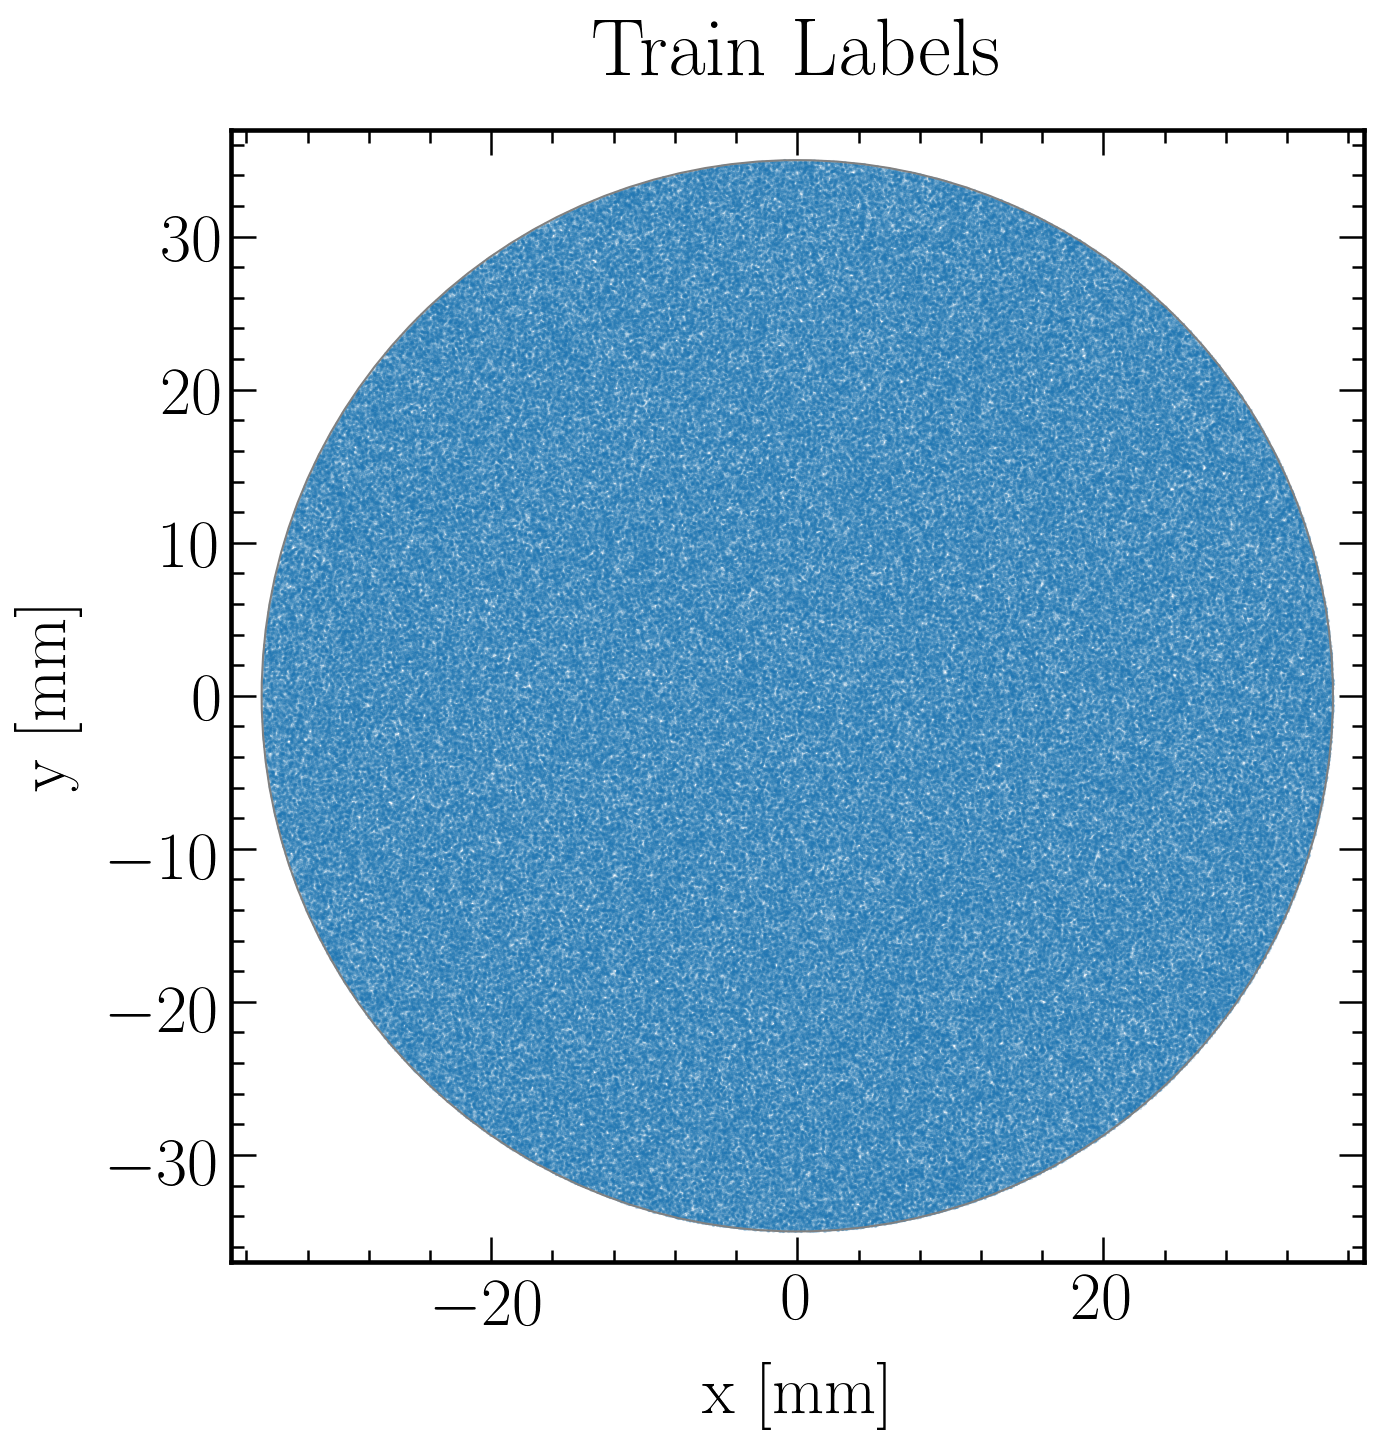

In [8]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.scatter(scaling_factor*train_label[:,0],
            scaling_factor*train_label[:,1],
            marker='.',
            s=1,
            #c='k',
            alpha = 0.2,
           )

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Train Labels', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

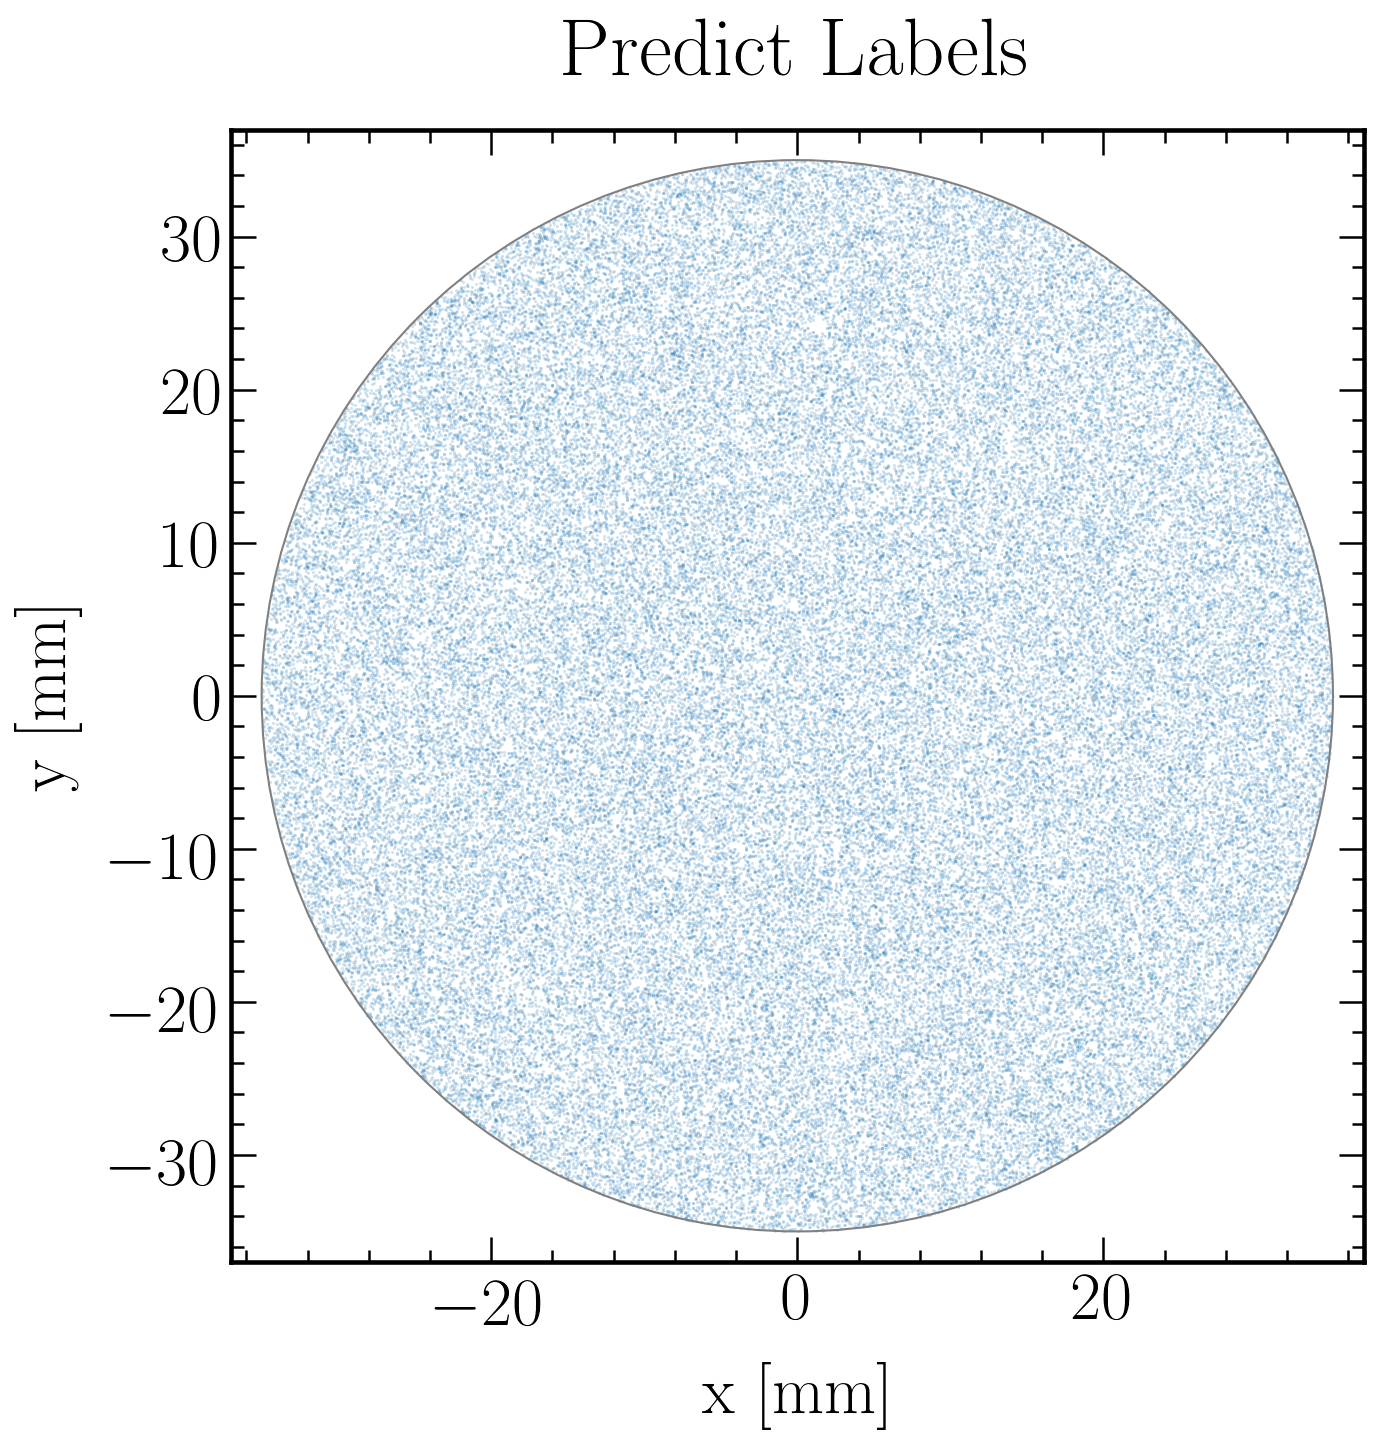

In [9]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.scatter(scaling_factor*predict_label[:,0],
            scaling_factor*predict_label[:,1],
            marker='.',
            s=1,
            #c='k',
            alpha = 0.2,
           )

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Predict Labels', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## Neural Network

### Building the Model

In [10]:
pmts = int(train_feature.shape[1]) # number of PMTs = 7
print('pmts = '+str(pmts)+' (type: '+str(type(pmts))+')')

model = Sequential([
    Dense(64, activation='relu', input_shape=(pmts,)),
    #Dropout(0.1),
    Dense(64, activation='relu'),
    #Dropout(0.1),
    Dense(2,  activation='linear'), # x and y
])

W0807 10:49:23.107310 139822228969280 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 10:49:23.126423 139822228969280 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 10:49:23.129622 139822228969280 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



pmts = 7 (type: <class 'int'>)


### Compiling the Model

In [11]:
opt = 'adam'
#opt = Adam(lr=0.005)
#opt = 'sgd'
#opt = SGD(lr=0.01, momentum=0.9)
#opt = SGD(lr=0.001, momentum=0.9)
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#opt = 'rmsprop'

model.compile(optimizer=opt,
              loss='mean_squared_error', 
              #metrics=['mean_squared_error', 'mean_squared_logarithmic_error', 'mean_absolute_error'],
             )

W0807 10:49:23.183043 139822228969280 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 4,802
Trainable params: 4,802
Non-trainable params: 0
_________________________________________________________________


In [13]:
plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB' # TB = vertical plot, LR = horizontal plot
)

In [14]:
ann_viz(model, view=True, filename="model_graph", title="Model Visualization")

### Training the Model

In [15]:
batchsize = 128

history_fit = model.fit(
    ## List of numpy arrays of training data / features.
    train_feature,
    ## List of numpy arrays of target (label) data.
    train_label,
    ## Number of epochs (iterations over the entire x and y data provided).
    epochs=30,
    ## Number of samples per gradient update. 
    ## If unspecified, batch_size will default to 32.
    ## Popular batch sizes in mini-batch gradient descent: 32, 64, 128 samples.
    batch_size=batchsize, 
    ## Fraction of the training data to be used as validation data. 
    ## The model will set apart this fraction of the training data, 
    ## will not train on it, and will evaluate the loss and any model metrics on 
    ## this data at the end of each epoch. 
    ## The validation data is selected from the last samples in the x and y 
    ## data provided, before shuffling.
    validation_split=0.2,
    ## Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    verbose=1,      
)

W0807 10:49:23.867185 139822228969280 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0807 10:49:24.050253 139822228969280 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 720000 samples, validate on 180000 samples
Epoch 1/30
720000/720000 [==============================] - 6s 9us/step - loss: 6.6623e-04 - val_loss: 4.6777e-04
Epoch 2/30
720000/720000 [==============================] - 6s 8us/step - loss: 4.2691e-04 - val_loss: 4.0675e-04
Epoch 3/30
720000/720000 [==============================] - 6s 8us/step - loss: 4.0677e-04 - val_loss: 4.0158e-04
Epoch 4/30
720000/720000 [==============================] - 6s 8us/step - loss: 3.9849e-04 - val_loss: 3.8833e-04
Epoch 5/30
720000/720000 [==============================] - 6s 9us/step - loss: 3.9386e-04 - val_loss: 4.0394e-04
Epoch 6/30
720000/720000 [==============================] - 6s 8us/step - loss: 3.9131e-04 - val_loss: 3.8952e-04
Epoch 7/30
720000/720000 [==============================] - 6s 8us/step - loss: 3.8843e-04 - val_loss: 3.8196e-04
Epoch 8/30
720000/720000 [==============================] - 6s 8us/step - loss: 3.8645e-04 - val_loss: 3.9832e-04
Epoch 9/30
720000/720000 [==========

In [16]:
print(history_fit.history.keys())

dict_keys(['val_loss', 'loss'])


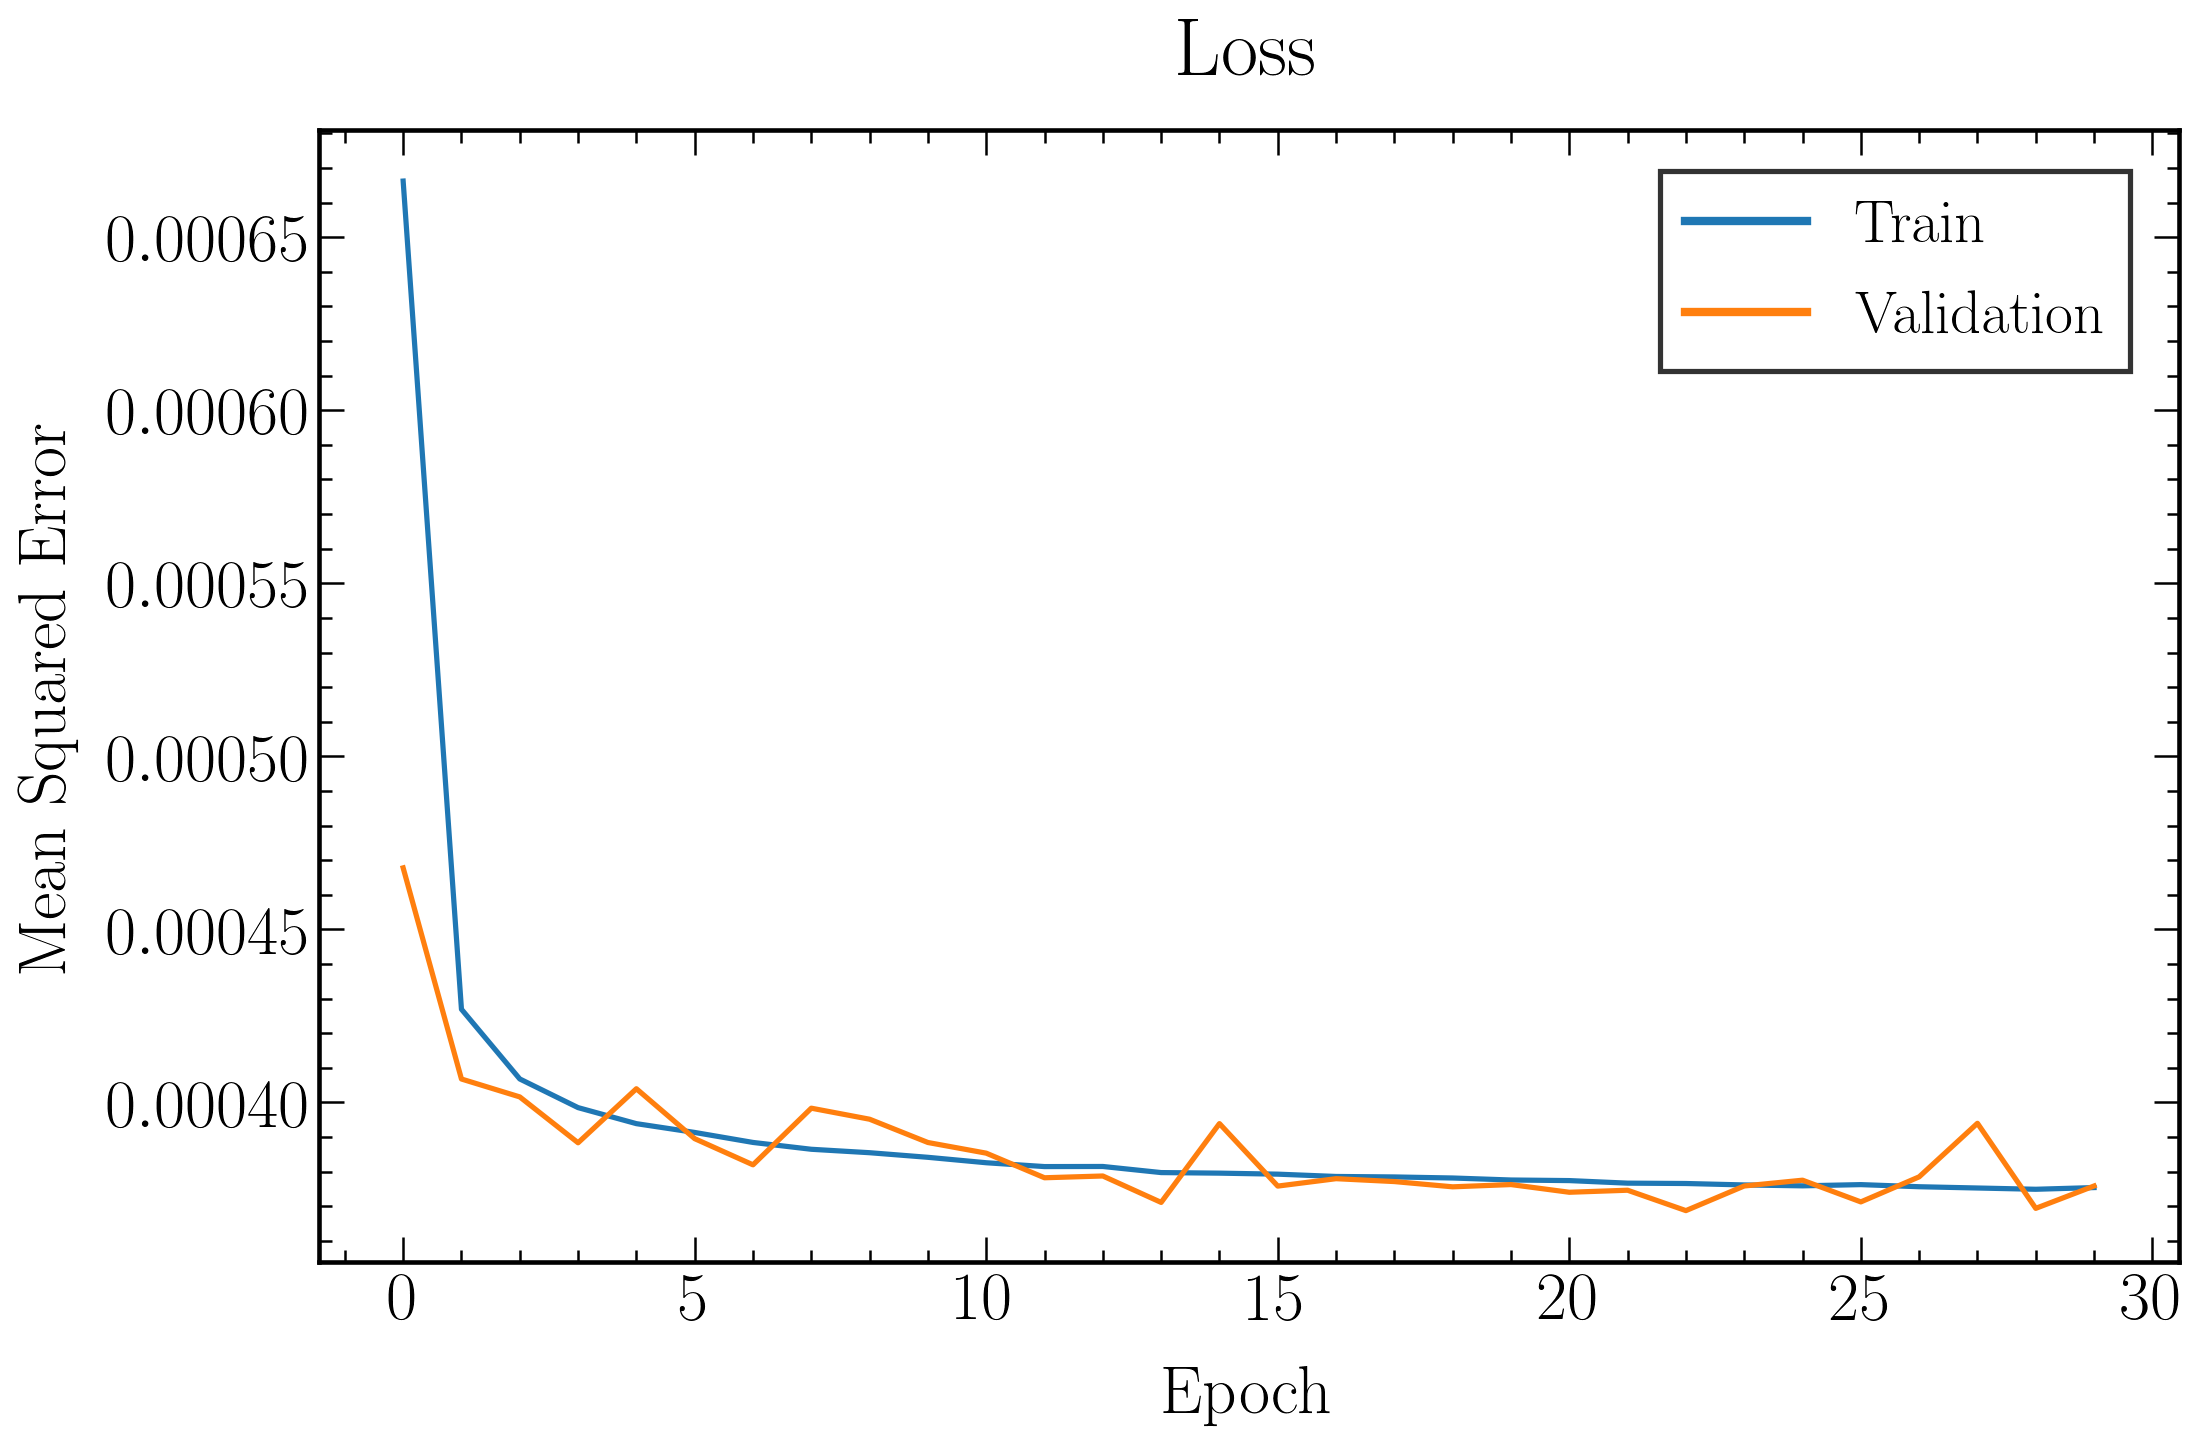

In [17]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.plot(history_fit.history["loss"], label = 'Train', linewidth = 2.5)
try:
    plt.plot(history_fit.history["val_loss"], label = 'Validation', linewidth = 2.5)
except:
    pass
#plt.yscale('log')

plt.xlabel('Epoch', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Mean Squared Error', fontsize = label_size, labelpad = label_pad)
plt.title('Loss', fontsize = title_size, pad = title_pad)

## Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

plt.show()

### Testing the Model

In [18]:
model.evaluate(
    predict_feature,
    predict_label,
    batch_size = batchsize
)

100000/100000 [==============================] - 0s 4us/step


0.00037466188231483104

### Using the Model

In [19]:
## Save the model('s weights) to disk
model.save_weights('model_weights.h5')
model.save('model.h5')

## Load the model('s saved weights)
#model = load_model('model.h5')
#model.load_weights('model_weights.h5')

In [20]:
## Use model to reconstruct positions
predictions = model.predict(predict_feature)

## Rescale
predictions = predictions*scaling_factor
train_label = train_label*scaling_factor
predict_label = predict_label*scaling_factor

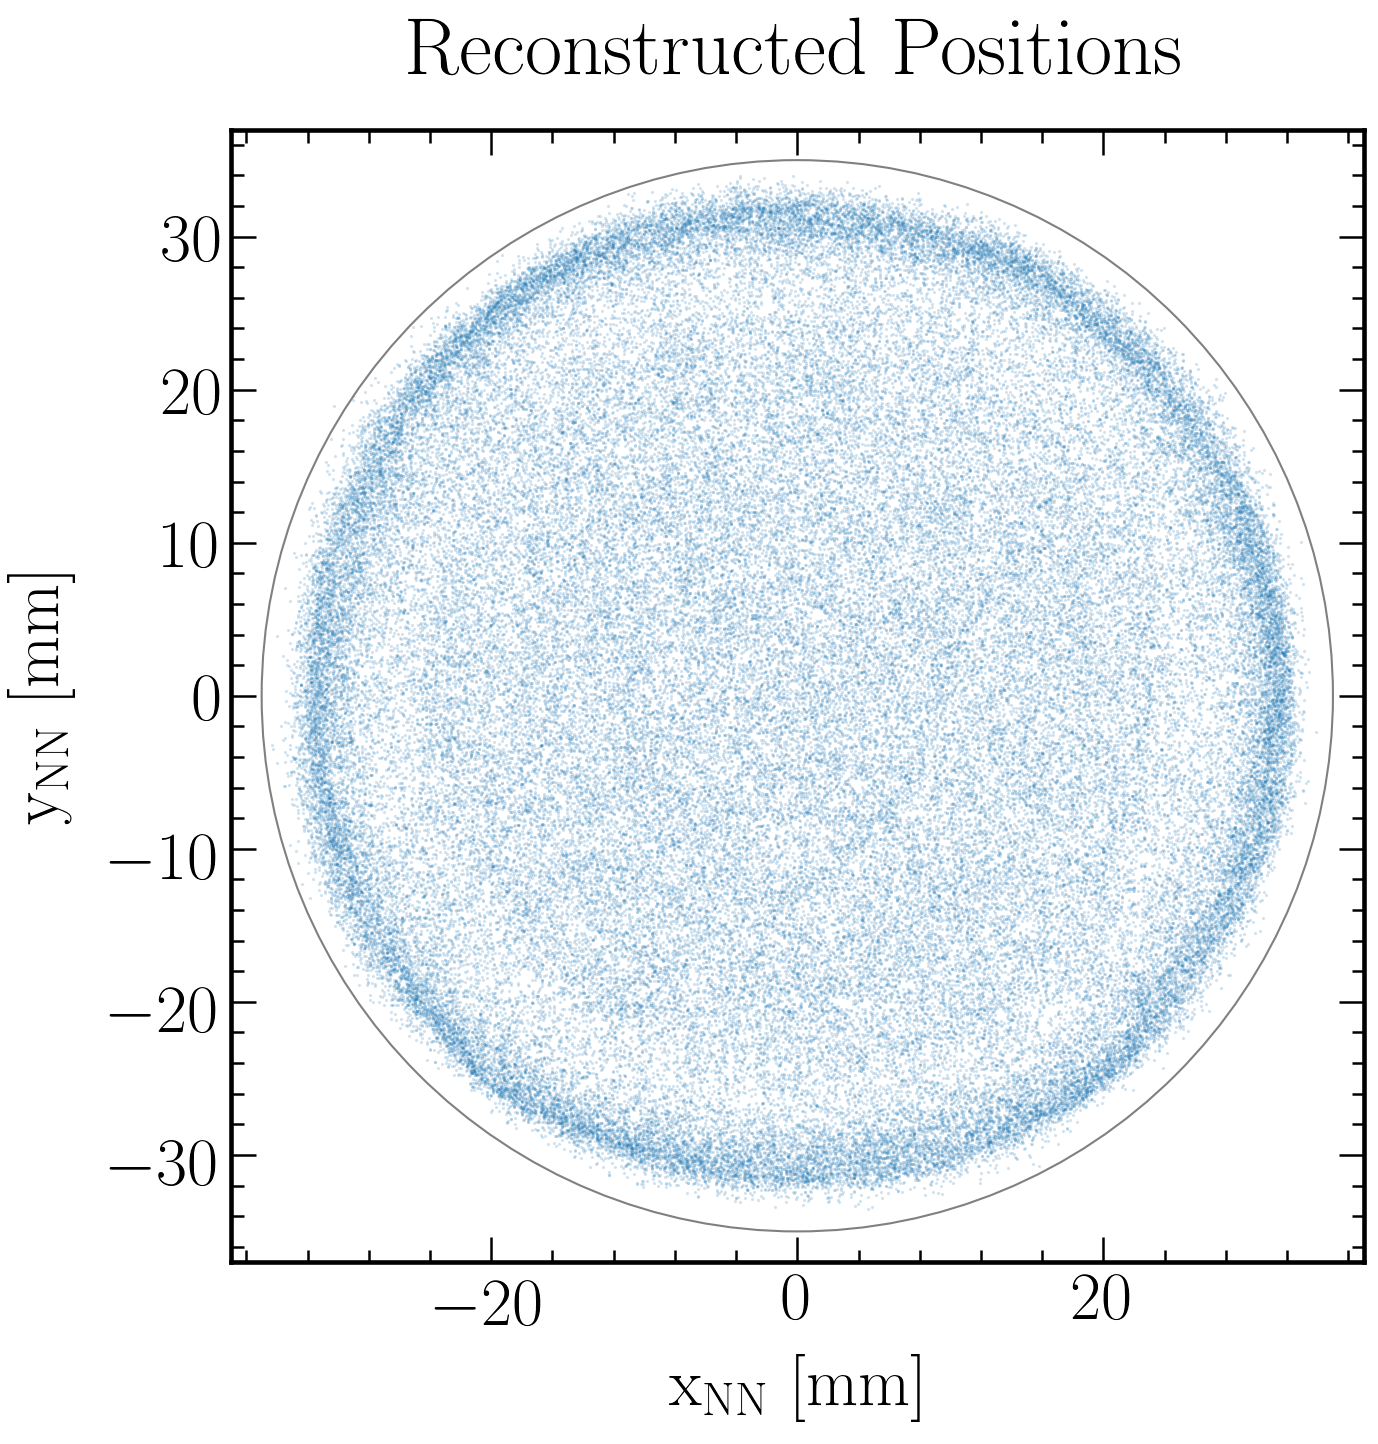

In [21]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.scatter(predictions[:,0],
            predictions[:,1],
            marker='.',
            s=1,
            #c='k',
            alpha = 0.2,
           )

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{NN}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{NN}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## Evaluation

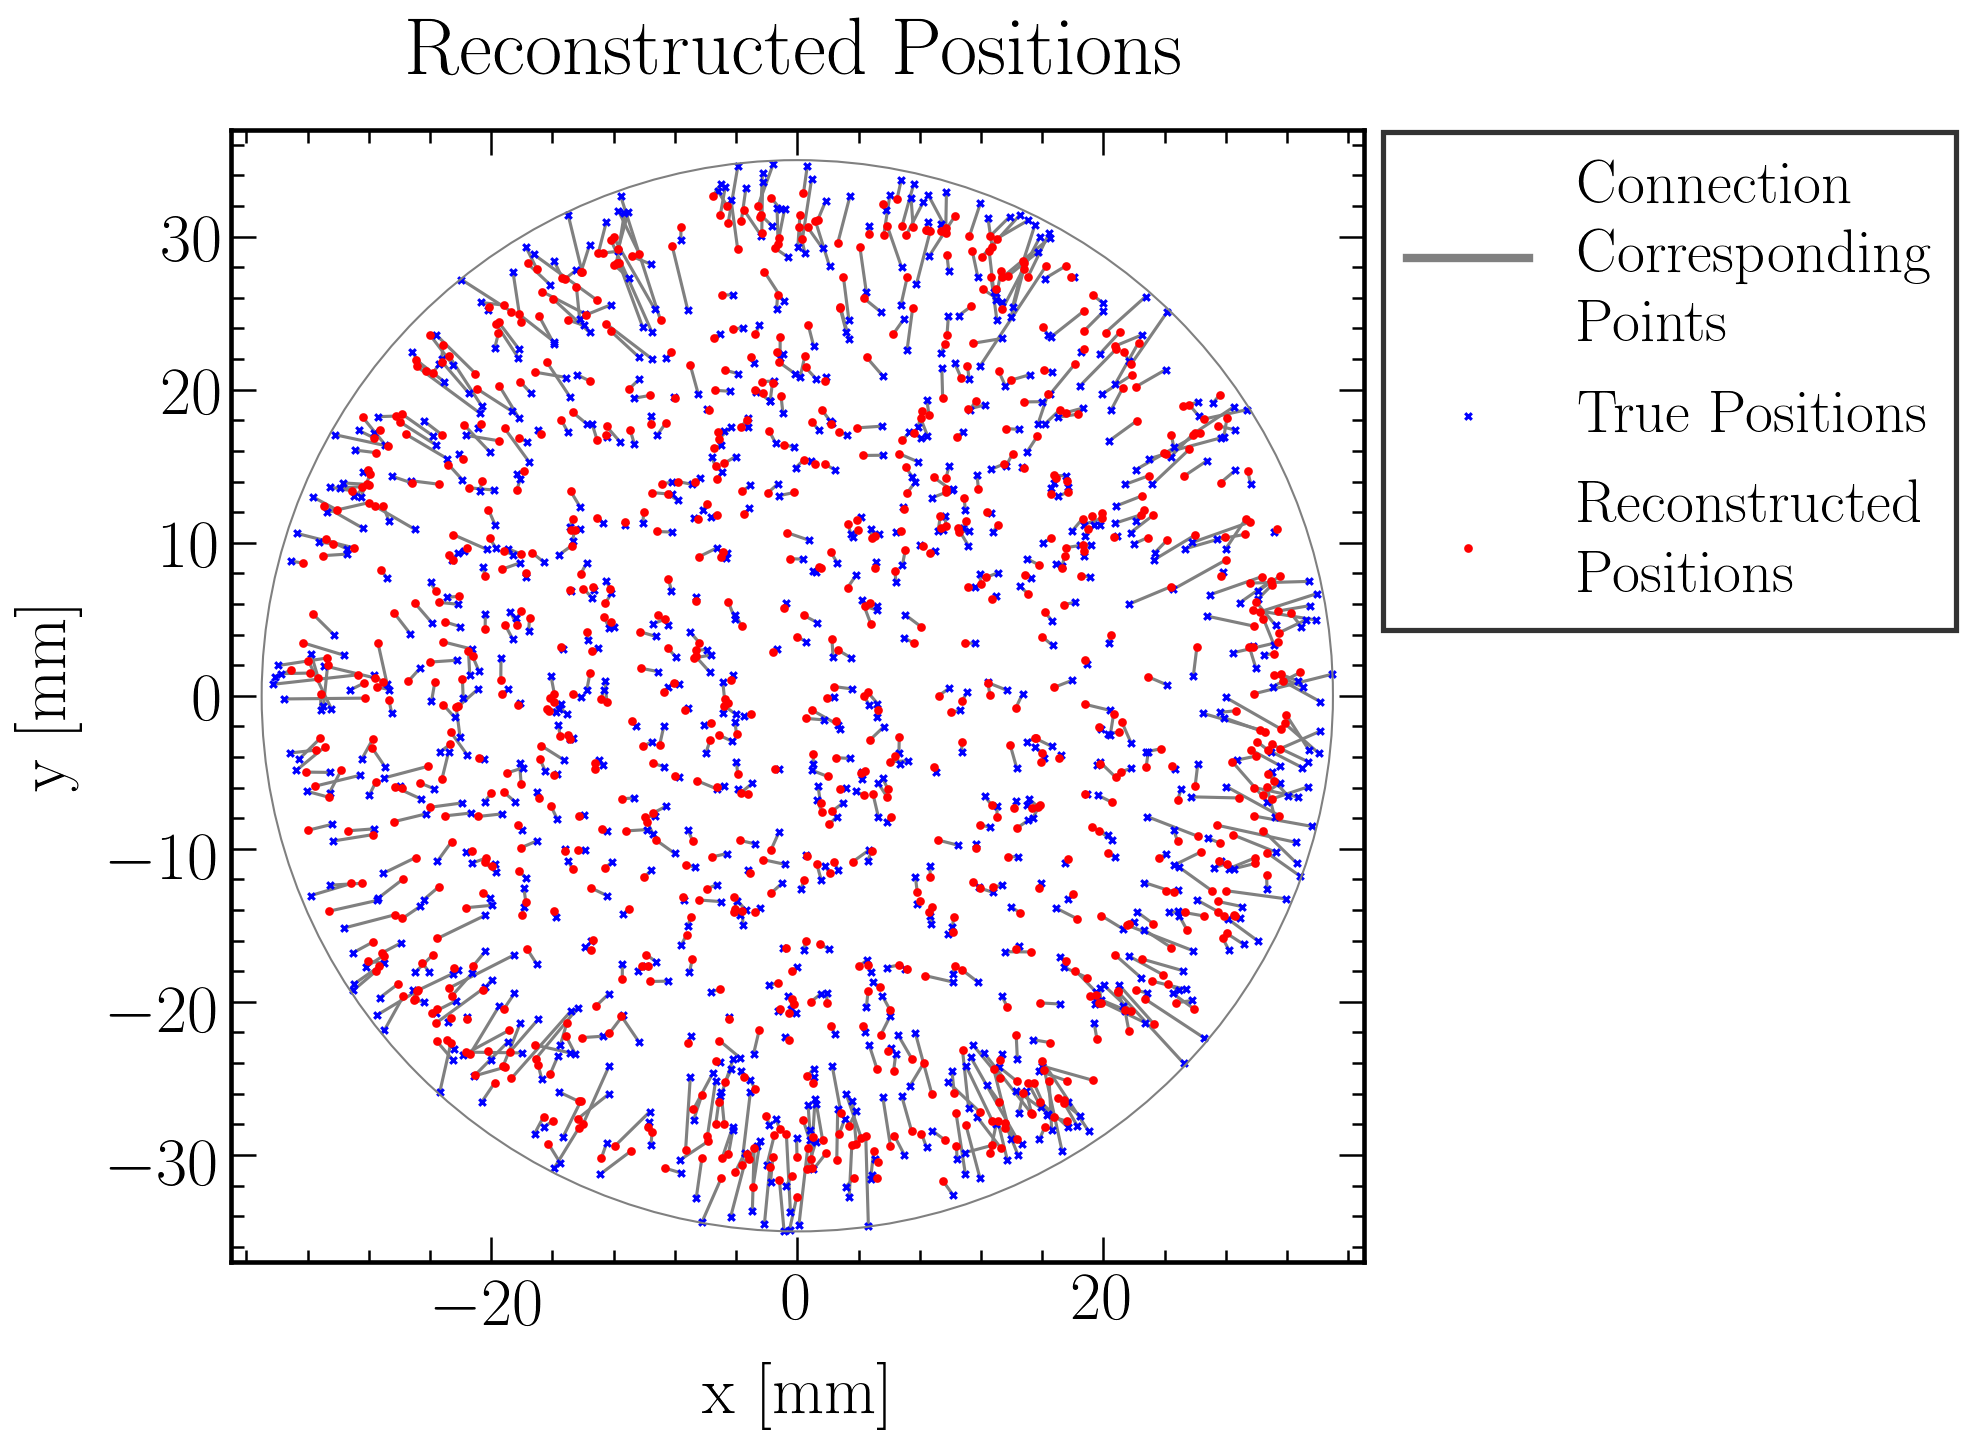

In [37]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)
    
#############################################
## Plot specific settings and plot data
#############################################

# Connect real and reconstructed position
red_sel = min(predict_label.shape[0], 1000)
plt.plot([predict_label[0:red_sel][0,0], predictions[0:red_sel][0,0]],[predict_label[0:red_sel][0,1], predictions[0:red_sel][0,1]], 'grey', label = 'Connection\nCorresponding\nPoints', zorder=0)
for i in range(1, len(predict_label[0:red_sel][:,0])):
    plt.plot([predict_label[0:red_sel][i,0], predictions[0:red_sel][i,0]],[predict_label[0:red_sel][i,1], predictions[0:red_sel][i,1]], 'grey', zorder=0)

# Data plot
plt.scatter(predict_label[0:red_sel][:,0], predict_label[0:red_sel][:,1], color = 'blue', s = 10, marker = 'x', label = 'True Positions')

plt.scatter(predictions[0:red_sel][:,0], predictions[0:red_sel][:,1], color = 'red', s = 10, label = 'Reconstructed\nPositions')

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-37.,37.)
plt.ylim(-37.,37.)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.99,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

plt.show()
fig.savefig(filenameprefix+"_ReconstructedPositionConnected_NN.png", bbox_inches = "tight")

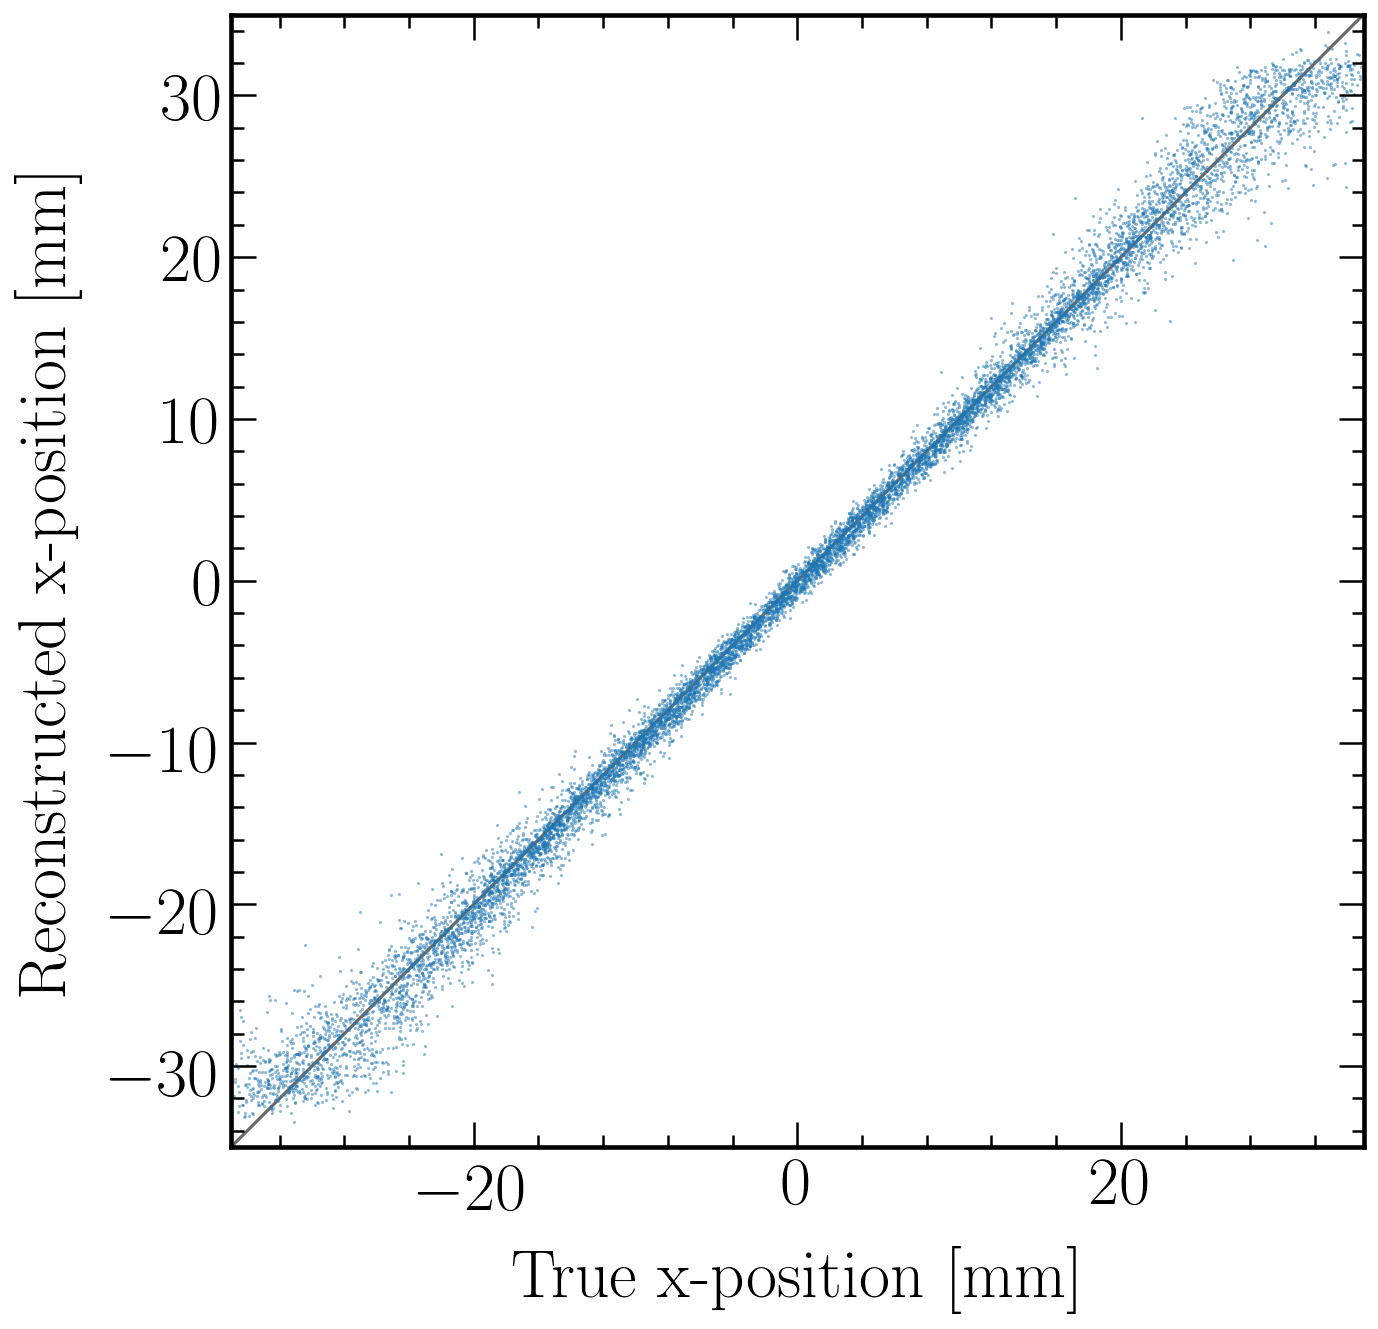

In [59]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
red_sel = min(predict_label.shape[0], 10000)

plt.scatter(predict_label[0:red_sel][:,0], 
            predictions[0:red_sel][:,0],
            marker='.',
            s=1,
            c='C0',
            alpha = 0.5,
           )

plt.plot([-35, 35], [-35, 35], 'dimgray', zorder = 0)


plt.xlabel('True x-position [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Reconstructed x-position [mm]', fontsize = label_size, labelpad = label_pad)
#plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-35.,35.)
plt.ylim(-35.,35.)

plt.show()
fig.savefig(filenameprefix+"_ReconstructedPositionCorrelationX_NN.png", bbox_inches = "tight")

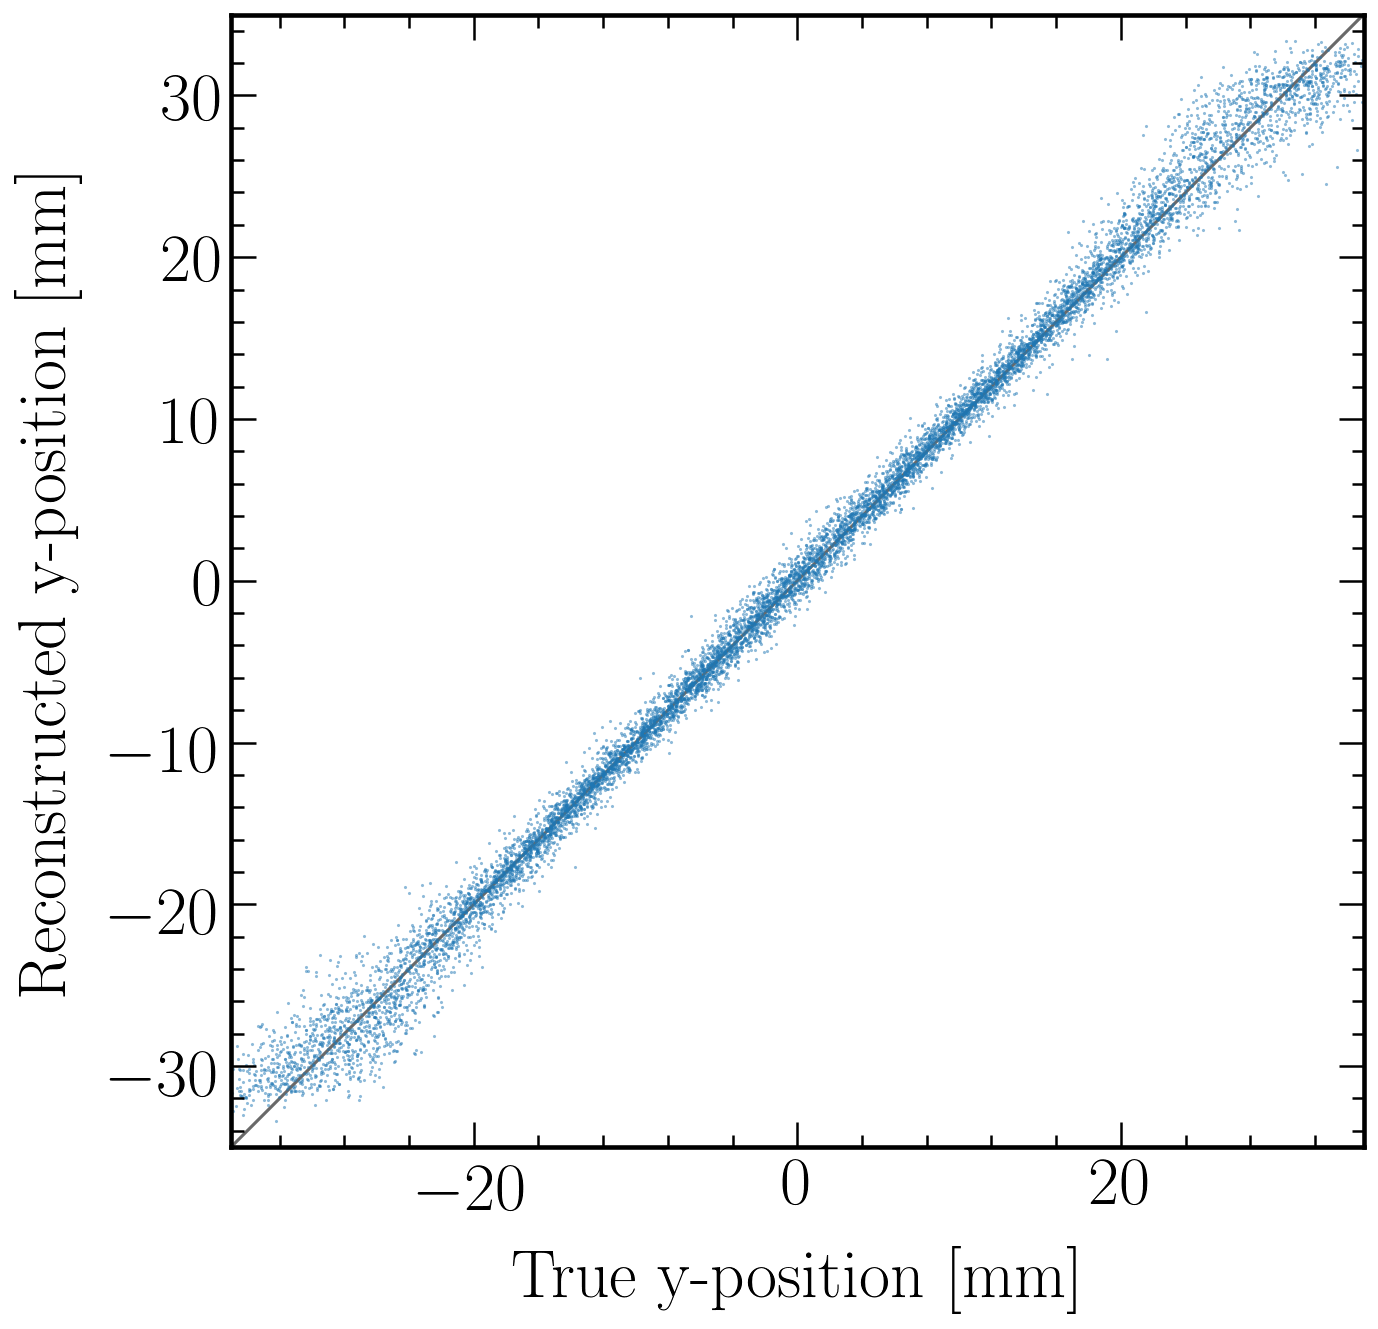

In [60]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
red_sel = min(predict_label.shape[0], 10000)

plt.scatter(predict_label[0:red_sel][:,1], 
            predictions[0:red_sel][:,1],
            marker='.',
            s=1,
            c='C0',
            alpha = 0.5,
           )

plt.plot([-35, 35], [-35, 35], 'dimgray', zorder = 0)


plt.xlabel('True y-position [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Reconstructed y-position [mm]', fontsize = label_size, labelpad = label_pad)
#plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-35.,35.)
plt.ylim(-35.,35.)

plt.show()
fig.savefig(filenameprefix+"_ReconstructedPositionCorrelationY_NN.png", bbox_inches = "tight")